# **Import needed libraries**

In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

2024-03-16 08:03:04.659715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 08:03:04.659812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 08:03:04.798808: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Loading the dataset**

> Read the training dataset into the dataframe

In [2]:
# loading the dataset
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df


# change label names to its original names
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 'lung_n': 'Lung_benign_tissue', 'lung_scc': 'Lung squamous_cell_carcinoma'}


    df[column_name] = df[column_name].replace(index)

In [3]:
# loading the data
data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
df = loading_the_data(data_dir)

change_label_names(df, 'labels')

df

filepaths               labels
0      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung_adenocarcinoma
1      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung_adenocarcinoma
2      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung_adenocarcinoma
3      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung_adenocarcinoma
4      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung_adenocarcinoma
...                                                  ...                  ...
14995  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung_benign_tissue
14996  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung_benign_tissue
14997  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung_benign_tissue
14998  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung_benign_tissue
14999  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung_benign_tissue

[15000 rows x 2 columns]

# **Data preprocessing**

first we will check if the training data is balanced or not

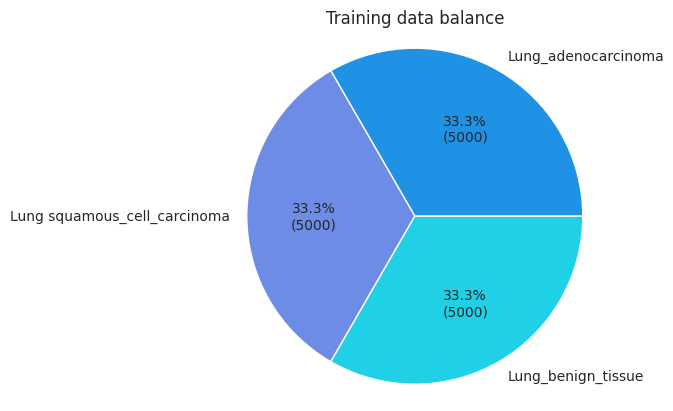

In [4]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

It is balanced, now we will split our data to train, val and test set

In [5]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

**Create image data generator**

in this step we will convert the whoole data to numpy arrays

In [6]:
# crobed image size
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


**Display sample from train data**

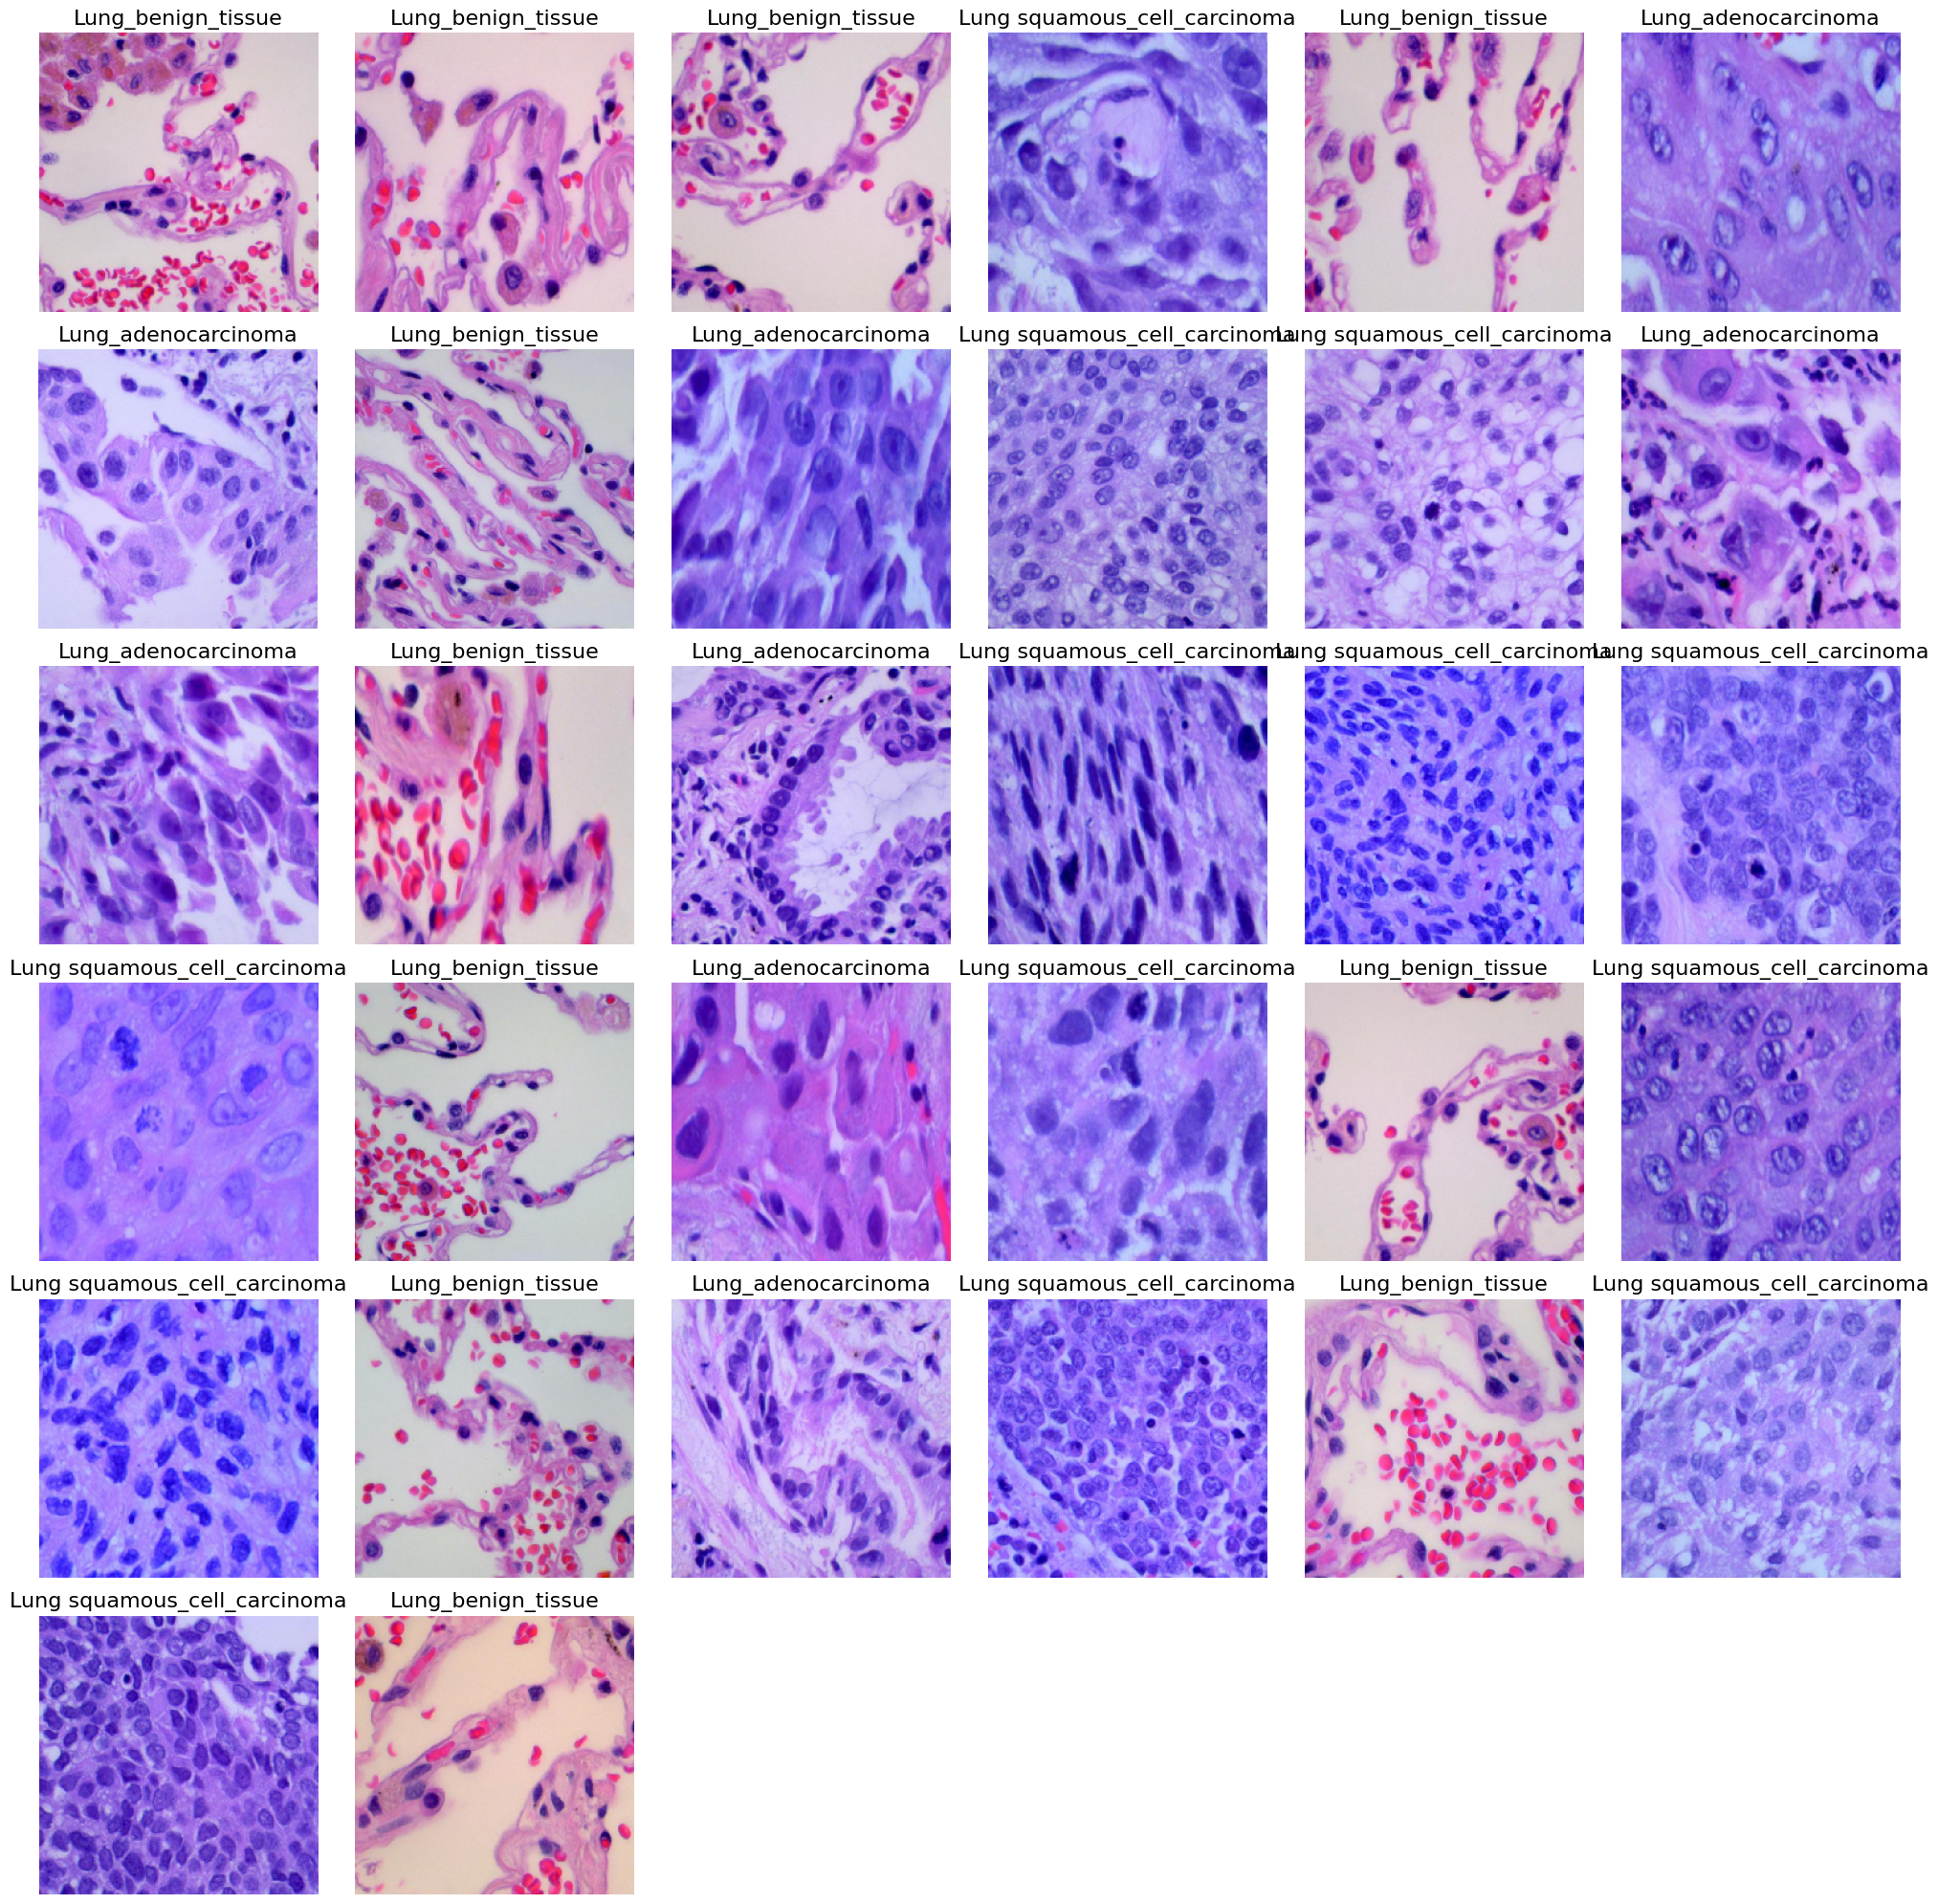

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Create needed functions**

In [8]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    

# Get Predictions
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()
    
    
# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())
    
    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

# **Model Structure**

# **CNN model**

In [9]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [10]:
# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv bolck
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))

# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(128, 0.5))

# second dense block
cnn_model.add(dense_block(64, 0.3))

# third dense block
cnn_model.add(dense_block(32, 0.2))

# output layer
cnn_model.add(Dense(class_counts, activation = "softmax"))

In [11]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 56, 56, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 14, 14, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 7, 7, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 128)            │     1,606,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,795,523 (10.66 MB)

 Trainable params: 2,794,083 (10.66 MB)

 Non-trainable params: 1,440 (5.62 KB)

In [12]:
# train the model
epochs = 20   # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
  2/375 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.2422 - loss: 2.0333   

I0000 00:00:1710576277.645670      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710576277.674089      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7749 - loss: 0.5612

W0000 00:00:1710576408.577524      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 176s 401ms/step - accuracy: 0.7751 - loss: 0.5608 - val_accuracy: 0.3180 - val_loss: 4.2505
Epoch 2/20


W0000 00:00:1710576427.874142      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 157ms/step - accuracy: 0.9096 - loss: 0.2451 - val_accuracy: 0.9607 - val_loss: 0.1270
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 157ms/step - accuracy: 0.9432 - loss: 0.1602 - val_accuracy: 0.8200 - val_loss: 0.5420
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.9534 - loss: 0.1409 - val_accuracy: 0.9267 - val_loss: 0.1970
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 63s 168ms/step - accuracy: 0.9576 - loss: 0.1202 - val_accuracy: 0.9473 - val_loss: 0.1266
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9631 - loss: 0.1042 - val_accuracy: 0.9813 - val_loss: 0.0586
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 163ms/step - accuracy: 0.9718 - loss: 0.0824 - val_accuracy: 0.9547 - val_loss: 0.1357
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 60s 159ms/step - accuracy: 0.9758 - loss: 0.0761 - val_accuracy: 0.9640 - val_loss: 0.0839
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - accuracy: 0.9789 - loss: 0.0621 - val

**Display model performance**

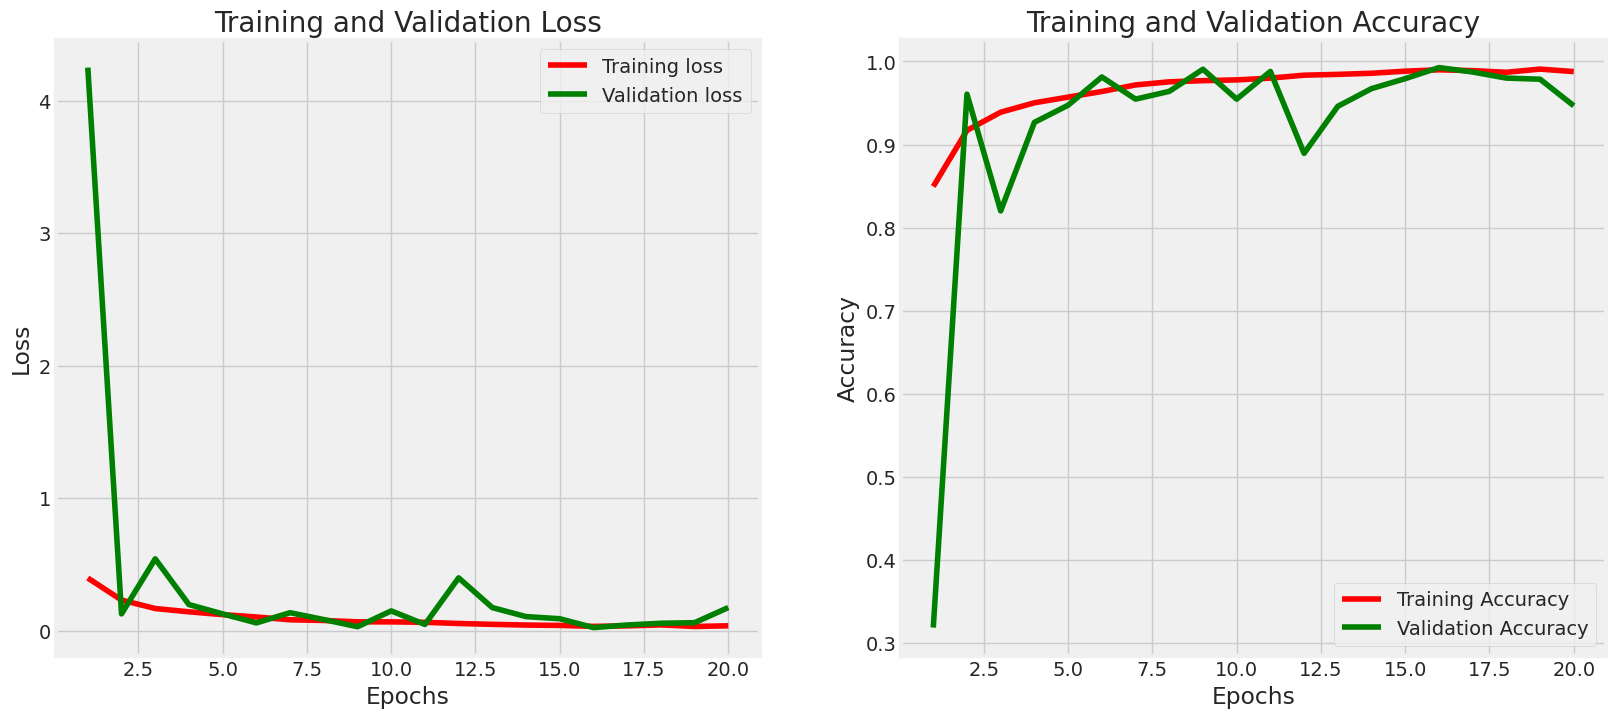

In [13]:
# Display model performance
model_performance(history, epochs)

**Evaluate the model**

In [14]:
# Model evaluation
model_evaluation(cnn_model)

375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 141ms/step - accuracy: 0.9627 - loss: 0.1261
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.9459 - loss: 0.1776
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 379ms/step - accuracy: 0.9482 - loss: 0.1853
Train Loss:  0.13261950016021729
Train Accuracy:  0.9610000252723694
--------------------
Validation Loss:  0.17451032996177673
Validation Accuracy:  0.9466666579246521
--------------------
Test Loss:  0.1770678609609604
Test Accuracy:  0.9520000219345093


**Get predictions and display the confusion matrix**

 3/47 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step

W0000 00:00:1710577668.743685      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step


W0000 00:00:1710577675.739482      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


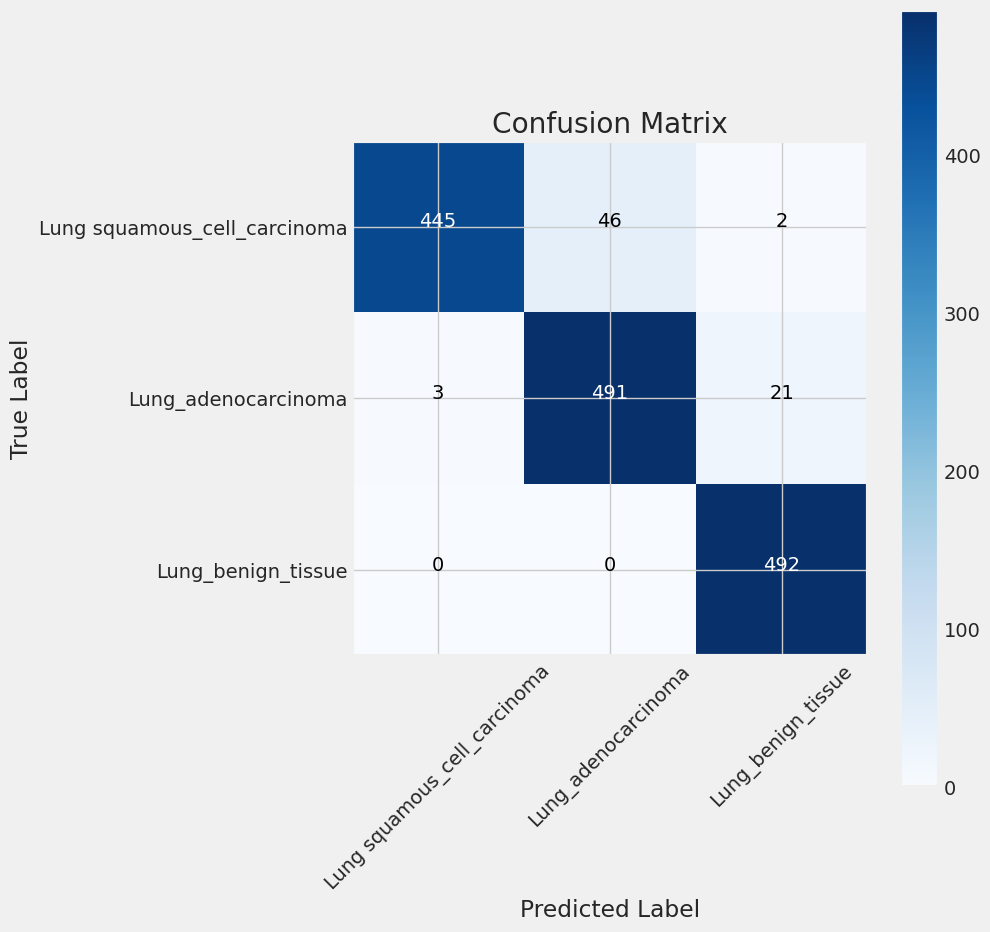

In [15]:
# get predictions
y_pred = get_pred(cnn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

# **EfficientNetB3**

In [16]:
# get the pre-trained model (EfficientNetB3)
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

# fine-tune EfficientNetB3 (Adding some custom layers on top)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation

# the model
EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [17]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_8[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,991,282 (41.93 MB)

 Trainable params: 10,900,587 (41.58 MB)

 Non-trainable params: 90,695 (354.28 KB)

In [18]:
# train the model
epochs = 20   # number of all epochs in training

EfficientNetB3_history = EfficientNetB3_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20


W0000 00:00:1710577865.334106      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6579 - loss: 0.7873

W0000 00:00:1710577970.383616      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 302s 333ms/step - accuracy: 0.6582 - loss: 0.7866 - val_accuracy: 0.3707 - val_loss: 1.2038
Epoch 2/20


W0000 00:00:1710577990.005514      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.8915 - loss: 0.2897 - val_accuracy: 0.6820 - val_loss: 0.7959
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9327 - loss: 0.1963 - val_accuracy: 0.9773 - val_loss: 0.0882
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 103s 273ms/step - accuracy: 0.9633 - loss: 0.1315 - val_accuracy: 0.9920 - val_loss: 0.0490
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9728 - loss: 0.1053 - val_accuracy: 0.9987 - val_loss: 0.0313
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 271ms/step - accuracy: 0.9836 - loss: 0.0764 - val_accuracy: 0.9987 - val_loss: 0.0205
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 101s 270ms/step - accuracy: 0.9863 - loss: 0.0598 - val_accuracy: 0.9980 - val_loss: 0.0168
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9866 - loss: 0.0568 - val_accuracy: 0.9987 - val_loss: 0.0119
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 271ms/step - accuracy: 0.9904 - loss: 0.04

**Display model performance**

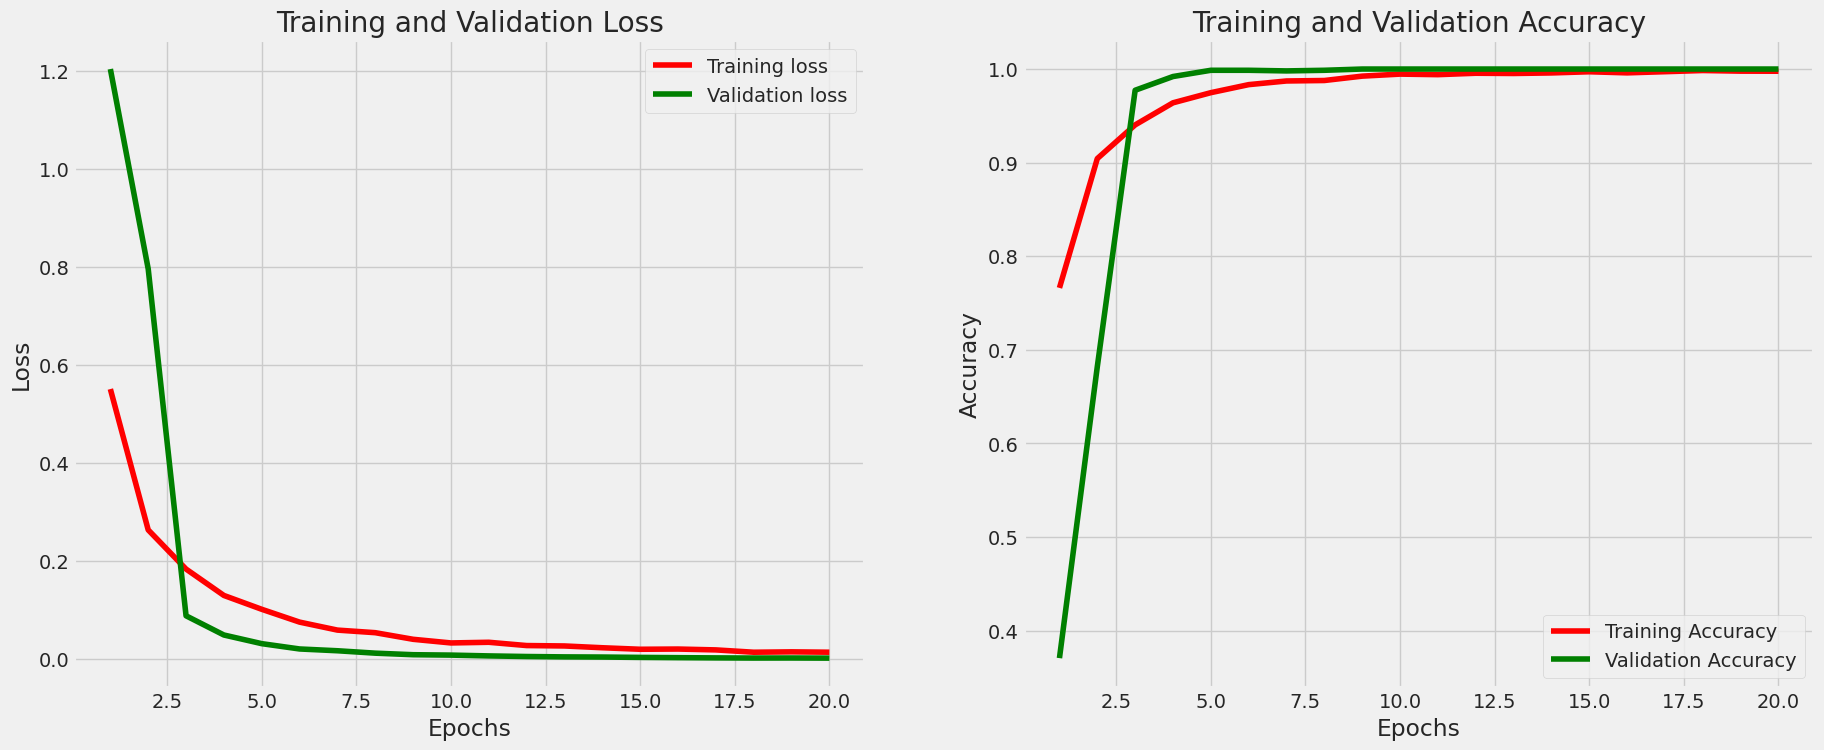

In [19]:
# Display model performance
model_performance(EfficientNetB3_history, epochs)

**Evaluate the model**

In [20]:
# Model evaluation
model_evaluation(EfficientNetB3_model)

375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - accuracy: 1.0000 - loss: 0.0011
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 1.0000 - loss: 0.0016
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.9999 - loss: 0.0023
Train Loss:  0.0010780951706692576
Train Accuracy:  1.0
--------------------
Validation Loss:  0.0017851245356723666
Validation Accuracy:  1.0
--------------------
Test Loss:  0.0031779510900378227
Test Accuracy:  0.9993333220481873


**Get predictions and display the confusion matrix**

 3/47 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step

W0000 00:00:1710580075.216771      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 364ms/step


W0000 00:00:1710580091.944768      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


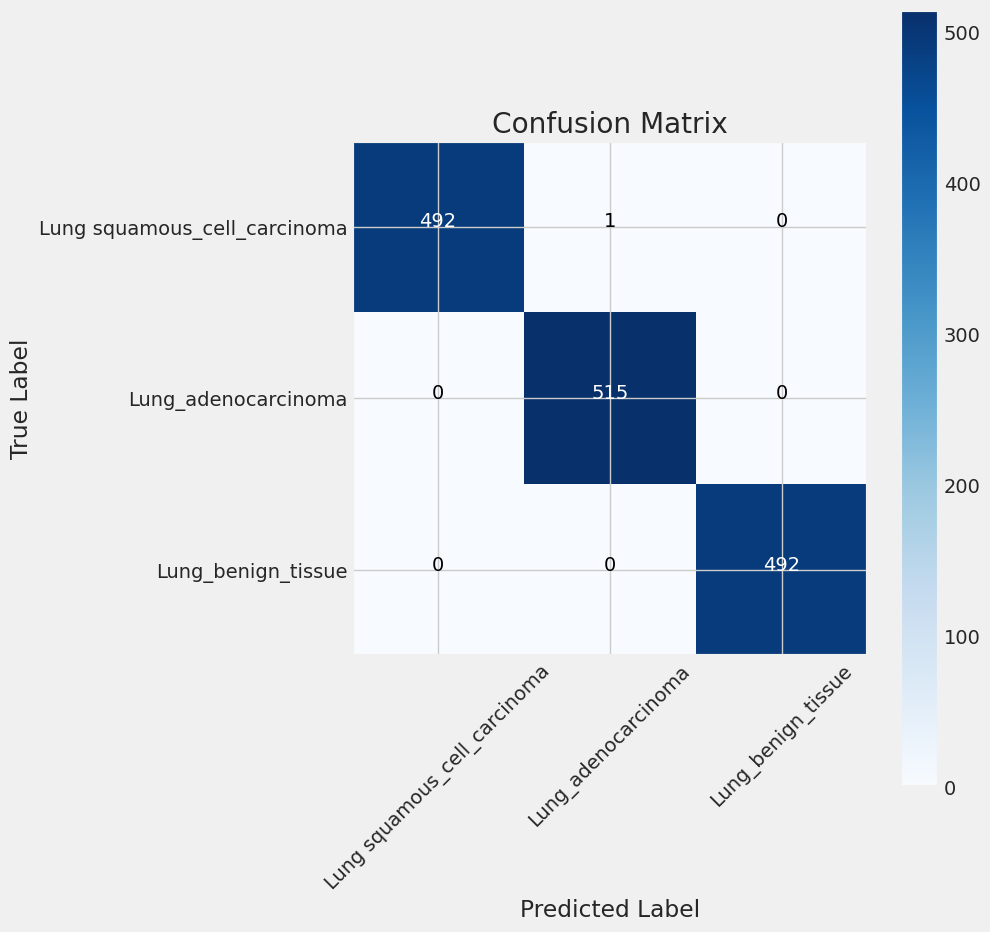

In [21]:
# get predictions
y_pred = get_pred(EfficientNetB3_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)